In [ ]:
! pip install easyocr
! pip install torchmetrics
! pip install pdf2image
! sudo apt-get install -y poppler-utils

In [ ]:
from PIL import Image
import os
from pdf2image import convert_from_path
import numpy as np
import torchmetrics

In [ ]:
import easyocr
reader = easyocr.Reader(['en','fr']) # this needs to run only once to load the model into memory

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [ ]:
! mkdir images
! mkdir texts
! mkdir KK-BOOKS-1971

In [ ]:
# from pdf to images
for file in os.listdir('/content/images'):
  if file.endswith('.pdf'):

    filepath = f'/content/images/{file}'
    doc = convert_from_path(filepath)
  
    folder_name = "-".join(file.split('-')[:3])
    for i in range(len(doc)):
      doc[i].save(f'/content/{folder_name}/image_{i+1}.png', 'PNG')

In [ ]:
original_text = []
for file in os.listdir('/content/texts'):
  with open(f'/content/texts/{file}', 'r', encoding='utf-8') as f:
    text = f.read()
    original_text.append(text)

In [ ]:
original_text = [o.replace('\t', '').replace('\n', '') for o in original_text]

In [ ]:
recognised_text = []
for file in os.listdir('/content/KK-BOOKS-1971'):
  result = reader.readtext(f'/content/KK-BOOKS-1971/{file}', detail = 0)
  recognised_text.append(result)

In [ ]:
recognised_text = [' '.join(t) for t in recognised_text]

In [ ]:
cer = torchmetrics.CharErrorRate()
model_result = cer(original_text, recognised_text)
print(f"CER: {model_result}")
print(f"Accuracy: {1 - model_result}")

CER: 0.8935492038726807
Accuracy: 0.10645079612731934


### Предварительная обработка изображений

In [ ]:
import matplotlib.pyplot as plt
from skimage import io, color, filters
from skimage.filters import threshold_yen # для бинаризации
from skimage import morphology # для dilation
from skimage import transform # de-skewing
import cv2

In [ ]:
! mkdir new_images

In [37]:
# Попробуем распознать данные

rt_after_preprocessing = []
images_path = '/content/KK-BOOKS-1971'

for i in range(1, 32):
  img = io.imread(f'{images_path}/image_{i}.png')
  gray_img = color.rgb2gray(img)
  
  threshold_value = filters.threshold_yen(gray_img)
  binary_img = gray_img > threshold_value

  selem = morphology.disk(1)
  angle = 1

  eroded_img = morphology.dilation(binary_img, selem)
  rotated_img = transform.rotate(eroded_img, angle)

  cv2.imwrite(f'/content/new_images/image_{i}.png', rotated_img)
  
  result = reader.readtext('/content/new_images/image_{i}.png', detail = 0)
  rt_after_preprocessing.append(result)

error: ignored

In [ ]:
rt_after_preprocessing = [' '.join(t) for t in rt_after_preprocessing]

In [ ]:
cer = torchmetrics.CharErrorRate()
model_result = cer(original_text, recognised_text)
print(f"CER: {model_result}")
print(f"Accuracy: {1 - model_result}")

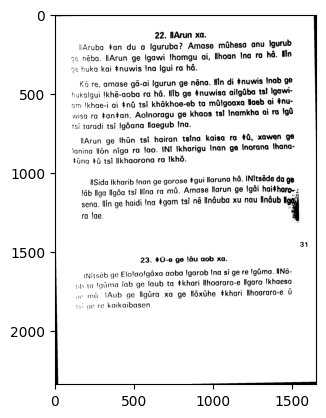

In [39]:
img = io.imread(f'{images_path}/image_16.png')
gray_img = color.rgb2gray(img)
  
threshold_value = filters.threshold_yen(gray_img)
binary_img = gray_img > threshold_value

angle = 1

rotated_img = transform.rotate(binary_img, angle)

plt.imshow(rotated_img, cmap='gray')
plt.show()

In [46]:
result = reader.readtext('/content/new_images/example.png', detail = 0)

In [47]:
result

['22, Inun xo',
 'Lerlbo Von du 0 [uruba} Amoso mûhbso anu Igurud',
 '76 ngbo Infun 08 Igawh Ihcmu 0 , Ihoan Ino r hà. Uln',
 'Ouko koi $nuwvis Ino Iqui r h,',
 "K' re, Omnose QJ-0i Igurun ge nôna Iln di 'nuw $ Inob 0",
 "hurolqui Ikh6 cobo ra ho , Ilb 00 'nuwlso ailqûbo Ial Ioawi",
 'om Ikhoe ; 0i inu 1s} khokhoo-ob ta',
 'müloooro Joeb 0i Inur',
 '2nsu f0 tanton. Aolnoraqu 00 khoos tal Inomkho 0i r Içj',
 'Jorudi {si Koono loequb Ino .',
 'Afua 90 Ihun',
 "hairon 'alna koipo r '0 'OMan %",
 'Pnino lon nign ro Joo [Mi Ikhoriqu Inon 0 Inorono Ihono:',
 'uno  u 138 Iknoorono / Ikho',
 '(Sida Ikharib Innn ge noras0 tqui Baruno ho INltsddo 00 %',
 'JZb 17j dgco tsi Fna ra mû   Amape Barun 0* Igê) hoithoro',
 'sena . Iln 9c hano; Inn Iopm tsi n Inaubo m nou Inbub [',
 'ro loe',
 '21 Wu 0 00 [61 Dou *,',
 'nAsœb q Elowoloano poba loaroo Ina 3i Qe r loumo INg',
 '80',
 '\'rjiv Iab q" loub 10 \'khori Ihoproro 0 Iooro Ikhocsq',
 'Wu',
 "[Aub 90 Igira K Ve [onuhe 'khori Lhoororo 0",
 '0',
 'Amk

### Обучение модели

In [ ]:
# импорты
import os
from trdg.generators import GeneratorFromStrings
import random
import yaml
import sys
import csv

In [ ]:
# загружаем txt файлы
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
texts_collection = []
for f in os.listdir('/content/drive/MyDrive/NAMA_OCR/texts'):
  if f.endswith('.txt'):
    with open(f"/content/drive/MyDrive/NAMA_OCR/texts/{f}", "r", encoding="utf-8") as f:
      text = f.read()
      texts_collection.append(text)

In [ ]:
# убираем пустые данные
texts_collection = [t for t in texts_collection if t != '']
# убираем знаки табуляции и переноса строки
texts_collection = [t.replace('\n', '').replace('\t', '') for t in texts_collection]

In [ ]:
# регулируем длину
texts_collection = [t for t in texts_collection if len(t) > 4]

for i, t in enumerate(texts_collection):
  if len(t) >= 65:
    texts_collection[i] = t[:30]
    texts_collection.append(t[len(t)+30:])

In [ ]:
with open('/content/drive/MyDrive/NAMA_OCR/texts_collections.csv', 'w') as f:
  csv_file = csv.writer(f)

  for line in texts_collection:
    csv_file.writerow(line)

Генерируем синтетический датасет

In [ ]:
generator1 = GeneratorFromStrings(
    strings=texts_collection,
    count=2500,
    blur=1
)

In [ ]:
generator2 = GeneratorFromStrings(
    strings=texts_collection,
    count=2500,
    blur=0
)

In [ ]:
!mkdir /content/dataset

In [ ]:
import PIL.Image
if not hasattr(PIL.Image, 'Resampling'):  # Pillow<9.0
    PIL.Image.Resampling = PIL.Image

filenames = []
targets = []

counter = 0
for img, lbl in generator1:
  if img != "" and lbl != "":
    img.save(f'/content/dataset/image_{counter}.jpeg', 'JPEG')
    targets.append(lbl)
    filenames.append(f'/content/dataset/image_{counter}.jpeg')
    counter += 1

In [ ]:
for img, lbl in generator2:
  if img != "" and lbl != "":
    img.save(f'/content/dataset/image_{counter}.jpeg', 'JPEG')
    targets.append(lbl)
    filenames.append(f'/content/dataset/image_{counter}.jpeg')
    counter += 1

Примеры

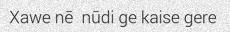

In [ ]:
# посмотрим на примеры
from PIL import Image

image = Image.open(f'/content/dataset/image_{random.randint(1, len(targets))}.jpeg')
image

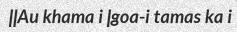

In [ ]:
image = Image.open(f'/content/dataset/image_{random.randint(1, len(targets))}.jpeg')
image

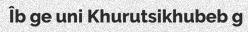

In [ ]:
image = Image.open(f'/content/dataset/image_{random.randint(1, len(targets))}.jpeg')
image

In [ ]:
#разделим выборку на тренировочную и тестовую
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(filenames, targets, test_size=0.2, random_state=42)

In [ ]:
!mkdir /content/train_data
!mkdir /content/test_data

In [ ]:
for filename in X_train:
  os.system(f'mv {filename} /content/train_data')

In [ ]:
for filename in X_test:
  os.system(f'mv {filename} /content/test_data')

In [ ]:
import csv  

header = ['filename', 'words']

with open('/content/train_data/labels.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    for i in range(len(X_train)):
      data = [X_train[i], y_train[i]]
      writer.writerow(data)

with open('/content/test_data/labels.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    for i in range(len(X_test)):
      data = [X_test[i], y_test[i]]
      writer.writerow(data)

In [ ]:
# сохраняем полученный набор данных
!cp -r /content/train_data /content/drive/MyDrive/NAMA_OCR
!cp -r /content/test_data /content/drive/MyDrive/NAMA_OCR

### Обучение модели

In [ ]:
#загружаем репозиторий для создания кастомной EasyOCR модели
! git clone https://github.com/JaidedAI/EasyOCR

Cloning into 'EasyOCR'...
remote: Enumerating objects: 2637, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 2637 (delta 51), reused 41 (delta 18), pack-reused 2542
Receiving objects: 100% (2637/2637), 152.91 MiB | 19.31 MiB/s, done.
Resolving deltas: 100% (1576/1576), done.
Updating files: 100% (305/305), done.


In [ ]:
#необходимо переместить train_data и test_data в trainer/all_data
!mv /content/train_data /content/EasyOCR/trainer/all_data
!mv /content/test_data /content/EasyOCR/trainer/all_data

In [ ]:
dict_file = {
    'number':'0123456789',
    'symbol':'"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ €',
    'lang_char': 'ǀǁǂ!ABCDEFGHIJKLNOPRSTUVWXabcdefghijklmnopqrstuvwxyzÂÊÎÔÛâêôûîĀĒĪŌŪāēīōū',
    'experiment_name':'khoekhoe_ocr',
    'train_data':'/content/EasyOCR/trainer/all_data',
    'valid_data':'/content/EasyOCR/trainer/all_data/test_data',
    'manualSeed': 1111,
    'workers':2,
    'batch_size':64,
    'num_iter': 5000,
    'valInterval': 1000,
    'saved_model': '',
    'FT': False,
    'optim': False, 
    'lr': 1,
    'beta1': 0.9,
    'rho': 0.95,
    'eps': 0.00000001,
    'grad_clip': 5,
    'select_data': 'train_data',
    'batch_ratio': '1',
    'total_data_usage_ratio': 1.0,
    'batch_max_length': 68,
    'imgH': 64,
    'imgW': 600,
    'rgb': False,
    'contrast_adjust': False,
    'sensitive': True,
    'PAD': True,
    'contrast_adjust': 0.0,
    'data_filtering_off': False,
    'Transformation': 'None',
    'FeatureExtraction': 'VGG',
    'SequenceModeling': 'BiLSTM',
    'Prediction': 'CTC',
    'num_fiducial': 20,
    'input_channel': 1,
    'output_channel': 256,
    'hidden_size': 256,
    'decode': 'greedy',
    'new_prediction': False,
    'freeze_FeatureFxtraction': False,
    'freeze_SequenceModeling': False 
    }

with open(r'/content/EasyOCR/trainer/config_files/khoekhoe_ocr.yaml', 'w') as file:
    documents = yaml.dump(dict_file, file)

In [ ]:
#смотрим на версии torch и torchtext
!pip3 show torchtext 
!pip3 show torch

Name: torchtext
Version: 0.6.0
Summary: Text utilities and datasets for PyTorch
Home-page: https://github.com/pytorch/text
Author: PyTorch core devs and James Bradbury
Author-email: jekbradbury@gmail.com
License: BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, requests, sentencepiece, six, torch, tqdm
Required-by: 
Name: torch
Version: 2.0.1
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, jinja2, networkx, nvidia-cublas-cu11, nvidia-cuda-cupti-cu11, nvidia-cuda-nvrtc-cu11, nvidia-cuda-runtime-cu11, nvidia-cudnn-cu11, nvidia-cufft-cu11, nvidia-curand-cu11, nvidia-cusolver-cu11, nvidia-cusparse-cu11, nvidia-nccl-cu11, nvidia-nvtx-cu11, sympy, triton, typing-extensions
Required-by: fastai, torchaudio, torchdata, torchtext, torchvision, triton


In [ ]:
# версия torch нам не подходит + их версии несовместимы
!pip3 uninstall torch -y

Found existing installation: torch 2.0.1
Uninstalling torch-2.0.1:
  Successfully uninstalled torch-2.0.1


In [ ]:
!pip3 install torchtext==0.6.0
!pip3 install torch==1.11.0

In [ ]:
# для того, чтобы осуществить импорт train.py и utils.py
sys.path.append('/content/EasyOCR/trainer')

In [ ]:
import torch.backends.cudnn as cudnn
from train import train
from utils import AttrDict
import pandas as pd

cudnn.benchmark = True
cudnn.deterministic = False

def get_config(file_path):
    with open(file_path, 'r', encoding="utf8") as stream:
        opt = yaml.safe_load(stream)
    opt = AttrDict(opt)
    if opt.lang_char == 'None':
        characters = ''
        for data in opt['select_data'].split('-'):
            csv_path = os.path.join(opt['train_data'], data, 'labels.csv')
            df = pd.read_csv(csv_path, sep='^([^,]+),', engine='python', usecols=['filename', 'words'], keep_default_na=False)
            all_char = ''.join(df['words'])
            characters += ''.join(set(all_char))
        characters = sorted(set(characters))
        opt.character= ''.join(characters)
    else:
        opt.character = opt.number + opt.symbol + opt.lang_char
    os.makedirs(f'./saved_models/{opt.experiment_name}', exist_ok=True)
    return opt

opt = get_config("/content/EasyOCR/trainer/config_files/khoekhoe_ocr.yaml")

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104impl8GPUTrace13gpuTraceStateE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
history = train(opt, amp=False)

Filtering the images containing characters which are not in opt.character
Filtering the images whose label is longer than opt.batch_max_length


AttributeError: ignored